In [1]:
import os
import tensorflow as tf
import numpy as np, pandas as pd, tensorflow as tf
import matplotlib.pyplot as plt

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})

REMOVE_DUPLICATE_EEG_IDS = True # if True, each row in training corresponds to a unique eeg_id
AVERAGE_TARGETS_OVER_EEG = False
MAX_ROWS = None # use only MAX_ROWS rows of train.csv, set to None to use all rows
USE_CACHE = True # stores all accessed eeg and spectrogram files in memory

DATA_DIR = 'data' # /kaggle/input/hms-harmful-brain-activity-classification/
READ_SPG_FILES = False
READ_EEG_SPG_FILES = False

2024-02-13 18:33:14.289244: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 18:33:14.289267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 18:33:14.290202: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 18:33:14.294745: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-13 18:33:14.896924: W tensorflow/compiler/tf2

2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-13 18:33:15.752072: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-13 18:33:15.780589: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-13 18:33:15.780805: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
train_csv = pd.read_csv(f'{DATA_DIR}/train.csv', dtype={'eeg_label_offset_seconds': 'int', 'spectrogram_label_offset_seconds': 'int'})
TARGETS = train_csv.columns[-6:]

def actual_median(s):
    return s.iloc[(s - s.median()).abs().argsort().iloc[0]]

if REMOVE_DUPLICATE_EEG_IDS:
    df_unique_eeg = train_csv.groupby('eeg_id')[['eeg_label_offset_seconds']].agg(actual_median)
    df_train = pd.merge(df_unique_eeg, train_csv, on=['eeg_id', 'eeg_label_offset_seconds'], how='left')
    
    if AVERAGE_TARGETS_OVER_EEG:
        y = train_csv.groupby('eeg_id')[TARGETS].agg('sum')
        y = y.div(y.sum(axis=1), axis=0)
        df_train[TARGETS] = y[TARGETS].values

df_train = df_train[:MAX_ROWS]

df_train

,eeg_id,eeg_label_offset_seconds,eeg_sub_id,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,568657,6,1,789577333,1,6,3640441665,20654,Other,0,0,3,0,2,7
1,582999,18,5,1552638400,5,18,1179854295,20230,LPD,0,12,0,1,0,1
2,642382,0,0,14960202,12,1008,3254468733,5955,Other,0,0,0,0,0,1
3,751790,0,0,618728447,4,908,2898467035,38549,GPD,0,0,1,0,0,0
4,778705,0,0,52296320,0,0,3255875127,40955,Other,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17084,4293354003,0,0,1188113564,0,0,447244163,16610,GRDA,0,0,0,0,1,1
17085,4293843368,0,0,1549502620,0,0,1618953053,15065,GRDA,0,0,0,0,1,1
17086,4294455489,0,0,2105480289,0,0,469526364,56,Other,0,0,0,0,0,1
17087,4294858825,6,2,657299228,2,6,3251917981,4312,Other,0,0,0,0,1,14


In [3]:
from functools import cache

def read_parquet(path):
    @cache
    def f(id_):
        return pd.read_parquet(f'{path}{id_}.parquet')
    return f

read_eeg_train = read_parquet(path=f'{DATA_DIR}/train_eegs/')
read_eeg_test = read_parquet(path=f'{DATA_DIR}/test_eegs/')
read_spg_train = read_parquet(path=f'{DATA_DIR}/train_spectrograms/')
read_spg_test = read_parquet(path=f'{DATA_DIR}/test_spectrograms/')

In [4]:
if READ_SPG_FILES:
    spgs = {}
    for i, spg_id in enumerate(df_train['spectrogram_id'].unique()):
        spgs[spg_id] = read_spg_train(spg_id).iloc[:, 1:].values
        if i % 1000 == 0:
            print(i, end=',')
else:
    spgs = np.load(f'{DATA_DIR}/specs.npy', allow_pickle=True).item()

eeg_spgs = np.load(f'{DATA_DIR}/eeg_specs.npy', allow_pickle=True).item()

In [5]:
import albumentations as albu

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=32, shuffle=False, augment=False, test_mode=False,
                 spgs=None, eeg_spgs=None):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.test_mode = test_mode
        self.spgs = spgs
        self.eeg_spgs = eeg_spgs
        if test_mode:
            self.read_spg = read_spg_test
            self.read_eeg = read_eeg_test
        else:
            self.read_spg = read_spg_test
            self.read_eeg = read_eeg_test
        self.on_epoch_end()
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        'Denotes the number of batches per epoch'
        n, r = divmod(len(self.data), self.batch_size)
        return n + (1 if r > 0 else 0)

    def __getitem__(self, i):
        'Generate one batch of data'
        indices = self.indices[(i * self.batch_size):((i + 1) * self.batch_size)]
        X, y = self.__data_generation(indices)
        if self.augment:
            X = self.__augment_batch(X) 
        return X, y
    
    def __data_generation(self, indices):
        X = np.zeros((len(indices), 128, 256, 8), dtype='float32')
        y = np.zeros((len(indices), 6), dtype='float32')
        # img = np.ones((128, 256), dtype='float32')

        for i, index in enumerate(indices):
            row = self.data.iloc[i]
            
            if self.spgs:
                spg = self.spgs[row['spectrogram_id']]
            else:
                spg = self.read_spg(row['spectrogram_id']).iloc[:, 1:].values
            
            if self.test_mode:
                spg_offset = 0
            else:
                spg_offset = row['spectrogram_label_offset_seconds'] // 2
            
            for j in range(4):
                img = spg[spg_offset:(spg_offset + 300), (j * 100):((j + 1) * 100)].T

                img = np.clip(img, np.exp(-4), np.exp(8))
                img = np.log(img)
                img = img - img.mean()
                img = img / (img.std() + 1e-6)
                img = np.nan_to_num(img, nan=0.0)

                X[i, :, :, j] = tf.image.resize(img[:, :, np.newaxis], (128, 256))[:, :, 0]  # EXPERIMENT: try resize_with_pad 

            
            if self.eeg_spgs:
                img = self.eeg_spgs[row['eeg_id']]
            else:
                pass  # TODO: implement
            
            img = (img - img.mean(axis=(0, 1))) / img.std(axis=(0, 1))
            X[i, :, :, 4:] = img

            if not self.test_mode:
                y[i, :] = row[TARGETS]
        return X, y
    
    def __random_transform(self, img):
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),
            #albu.CoarseDropout(max_holes=8,max_height=32,max_width=32,fill_value=0,p=0.5),
        ])
        return composition(image=img)['image']
            
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ] = self.__random_transform(img_batch[i, ])
        return img_batch


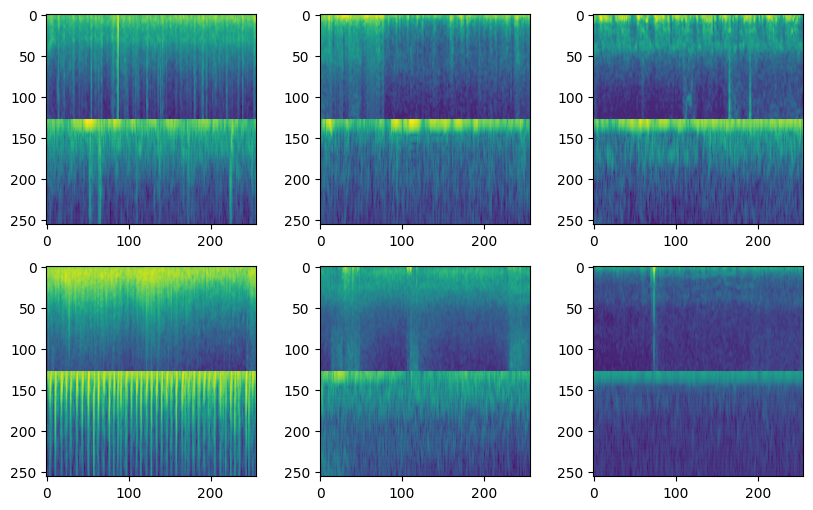

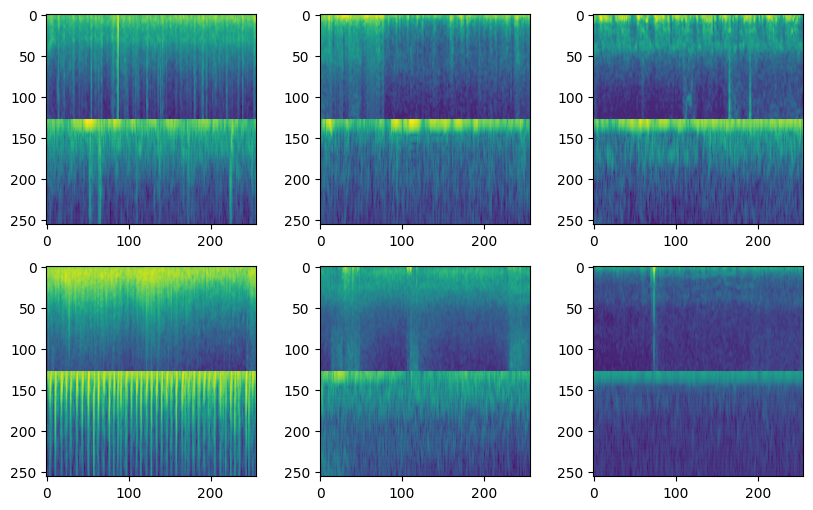

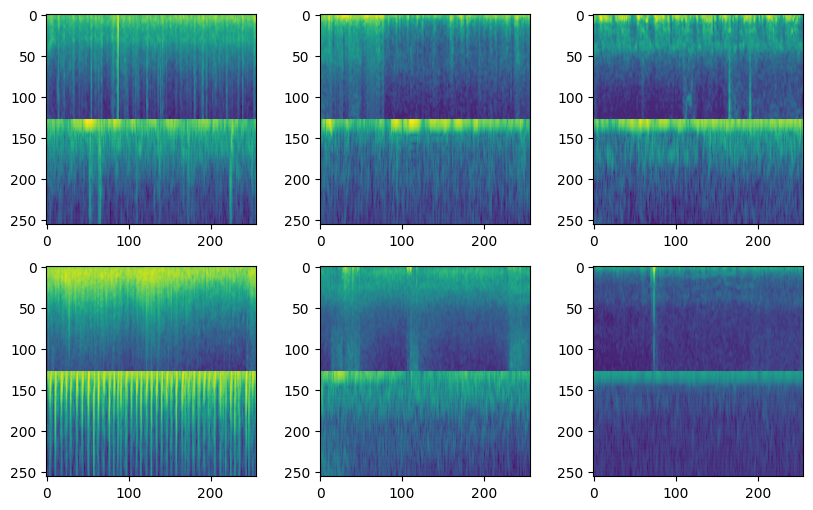

In [32]:
gen = DataGenerator(df_train, spgs=spgs, eeg_spgs=eeg_spgs, shuffle=False)

ROWS = 2
COLS = 3
BATCHES = 3

for i, (X, y) in enumerate(gen):
    plt.figure(figsize=(10, 6))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j * COLS + k + 1)
            t = y[j * COLS + k]
            img = np.concatenate([X[j * COLS + k, :, :, a] for a in [0, 4]], axis=0)
            plt.imshow(img)
    plt.show()
    if i == BATCHES - 1:
        break